In [30]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # plot data
!pip install iisignature
import iisignature as ii #generate signatures
from sklearn import preprocessing #scaling
from xgboost import XGBRegressor# regression model
pd.set_option("display.max_rows", None, "display.max_columns", None)
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
import sys
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# import warnings
# warnings.filterwarnings("ignore")

/kaggle/input/mlchallengedata/Germany 10-Year Bond Yield Historical Data.csv
/kaggle/input/mlchallengedata/SP 500 Historical Data.csv
/kaggle/input/mlchallengedata/bond_2.csv
/kaggle/input/mlchallengedata/stock_2.csv
/kaggle/input/mlchallengedata/DAX Historical Data.csv
/kaggle/input/mlchallengedata/CBOE Volatility Index Historical Data.csv
/kaggle/input/mlchallengedata/United States 10-Year Bond Yield Historical Data.csv
/kaggle/input/mlchallengedata/Gold Futures Historical Data.csv
/kaggle/input/mlchallengedata/commodity_2.csv
/kaggle/input/mlchallengedata/NASDAQ Composite Historical Data.csv
/kaggle/input/mlchallengedata/GBP_USD Historical Data.csv
/kaggle/input/mlchallengedata/United Kingdom 10-Year Bond Yield Historical Data.csv
/kaggle/input/mlchallengedata/Crude Oil WTI Futures Historical Data.csv
/kaggle/input/mlchallengedata/USD_JPY Historical Data.csv
/kaggle/input/mlchallengedata/US Dollar Index Futures Historical Data.csv
/kaggle/input/mlchallengedata/EUR_USD Historical Dat

**Predicting target market returns based on time series signature of other markets**

In this notebook large datasets of market prices are used to predict the return on a trade for a specific market. We will construct a time series of previous market prices eg (NASDAQ, VIX, SP500). From this time series we extract the signature of the time series, which compresses the essential features of the data into one list of numbers. We train a gradient boosting model on these signatures to produce the return. This method is inspired by a article I read at: https://towardsdatascience.com/predict-bitcoin-prices-by-using-signature-time-series-modelling-cf3100a882cc

Main datasource: Investing.com

In [31]:
#these are the file pathsof our datasets. each dataset has a code to reference it in the csv. 
#The code of each dataset is needed for the input dictionary in generate_dataset().
#the code for each dataset is the code at the beginning of the path i.e OIL_path has code OIL
#file paths will need to be updated when running on another computer

codes = ["NASDAQ", "SP500", "DAX", "VIX", "US10Y", "UK10Y", "GER10Y", "CR_OIL", "OIL", "GOLD", "DI", "USEUR", "GBPUS", "USJPY"] #shortcodes for each dataset needed in dict

NASDAQ_path = "../input/mlchallengedata/NASDAQ Composite Historical Data.csv"
SP500_path = "../input/mlchallengedata/SP 500 Historical Data.csv"
DAX_path = "../input/mlchallengedata/DAX Historical Data.csv"
VIX_path = "../input/mlchallengedata/CBOE Volatility Index Historical Data.csv"
US10Y_path = "../input/mlchallengedata/United States 10-Year Bond Yield Historical Data.csv"
UK10Y_path = "../input/mlchallengedata/United Kingdom 10-Year Bond Yield Historical Data.csv"
GER10Y_path = "../input/mlchallengedata/Germany 10-Year Bond Yield Historical Data.csv"
CR_OIL_path = "../input/mlchallengedata/Crude Oil WTI Futures Historical Data.csv"
OIL_path = "../input/mlchallengedata/Brent Oil Futures Historical Data.csv"
GOLD_path = "../input/mlchallengedata/Gold Futures Historical Data.csv"
DI_path = "../input/mlchallengedata/US Dollar Index Futures Historical Data.csv"
USEUR_path = "../input/mlchallengedata/EUR_USD Historical Data.csv"
GBPUS_path = "../input/mlchallengedata/GBP_USD Historical Data.csv"
USJPY_path = "../input/mlchallengedata/USD_JPY Historical Data.csv"

#path to access target market files i.e stock_1.csv. we leave it like this to be formatted in generate_dataset()
Market_path = "../input/mlchallengedata/{}.csv"

In [32]:
# funtion used to generate a datafram containing past [window_size] days. function takes in the target market we want to 
# model e.g "bond_1", a dictionary containing key value pair of market code and market file path for the datasets we want to model off. 


def generate_dataset(Market: str, Datapaths: dict, window_size: int):  
    #load in dataset
    data = pd.read_csv(Market_path.format(Market)) 
    data = data.drop(["Position_Close", "Market"], axis=1)
    data = data.rename(columns = {"Position_Open":"Date"})
    data["Date"] = pd.to_datetime(data["Date"]).dt.date
    data.set_index('Date', inplace=True)
    
    # normalise returns to make model more accurate
    minimum_return = min(data["Return"])
    maximum_return = max(data["Return"])
    ratio = minimum_return/maximum_return
    
    min_max_scaler = preprocessing.MinMaxScaler(feature_range=(-1,-1/ratio))
    x = data[["Return"]].values.astype(float)
    x_scaled = min_max_scaler.fit_transform(x)
    data[["Return"]] = x_scaled
        
    for i in range(len(Datapaths)):
        # for each data set specified in datapaths we load in the dataset
        aux = pd.read_csv(list(Datapaths.values())[i], thousands=',')
        aux["Date"] = pd.to_datetime(aux["Date"]).dt.date
        aux.set_index("Date", inplace=True)
        
        # normalise data in each dataset
        min_max_scaler = preprocessing.MinMaxScaler()
        x = aux[[list(Datapaths.keys())[i]]].values.astype(float)
        x_scaled = min_max_scaler.fit_transform(x)
        aux[[list(Datapaths.keys())[i]]] = x_scaled
        

        for j in range(1, window_size):
           # add previous values of markets in order to construct a time series later
            aux[list(Datapaths.keys())[i]+"lag_{}".format(j)] = aux[list(Datapaths.keys())[i]].shift(-j)
            
        #add market values to dataframe
        data = pd.concat([aux, data], axis =1) #add market values to dataframe
        
    # reverse dataframe such that most recent date is last, so that we can run tests on recent data
    data = data.iloc[::-1]
    #eliminate dates that dont have a return as they are useless
    data = data.dropna()
                
      
    return data
        
        

In [33]:
 # this function takes in a dataframe created by generate_dataset() and uses it to construct a time series of 
 # previous market data of size: window_size. from this the time series signature is extracted and stored in the
 # dataframe to be used at training time

def generate_signatures(data, window_size, num, siglength):
     # initialize array to store time series data
    time_series = np.zeros((len(data), window_size, num))
    
    for i in range(len(data)):
        y=data.iloc[i][:-1]
        for j in range(num):
             # assign each time series to array
            time_series[i, :,j] = np.flip(np.array(y[window_size*j:window_size*(j+1)]), axis=0)
    
    # construct signature matrix to store calculates signatures from time series
    signatures = np.zeros((len(data),siglength))

    for i in range(len(data)):
        x = time_series[i,:,:]
        sig = ii.sig(x, truncation)  
        signatures[i,:] = sig #assign signature list to signature array
        
    #create new dataframe to store signatures
    Sigs = pd.DataFrame()
    Sigs["Return"] = data["Return"]
    
    
    #add each signature to the dataframe aligned with each return. 
    #One return has a list of length siglength containing signature data of time-series
    for i in range(1,siglength+1):
        Sigs["Signature "+str(i)] = signatures[: , i-1]
        
    #return dataframe containing return and signature data to be used in training
    return Sigs
        
    

In [34]:
#this method uses generate_dataset and generate_signatures to produce training data based on function inputs
#training data used to train a gradient boosting regression model. method returns the model itself as well as 
#train and test predictions


def generate_model(Market, Datapaths, window_size, truncation, learning_rate, test_start_date):
    #num is the number of channels in the time series
    num = len(Datapaths)
    #siglength is the number of terms in time series signature
    siglength = ii.siglength(num, truncation)
    #the date from which we want to test model
    test_start_date = pd.to_datetime(test_start_date).date()
    #generate dataset from which we produce signatures based on datapaths
    data = generate_dataset(Market, Datapaths, window_size)
    #generate signatures based on previously generated dataset
    signatures = generate_signatures(data, window_size, num, siglength)
    #split signatures into train and test sets based on the date from which we want to start testing
    train_signatures = signatures.loc[:test_start_date]
    test_signatures = signatures.loc[test_start_date:]
    #convert dataframe into X and Y array to be used in training
    X_train = np.array(train_signatures[["Signature "+str(i+1) for i in range(siglength)]])
    X_test = np.array(test_signatures[["Signature "+str(i+1) for i in range(siglength)]])
    Y_train = np.array(train_signatures["Return"])


    #We use a gradient boosting regression model with learning rate taken as parameter to function
    Model = XGBRegressor(learning_rate=learning_rate,
                                n_estimators=500,
                                max_depth=5,
                                min_child_weight=5,
                                gamma=0,
                                subsample=0.8,
                                colsample_bytree=0.8, 
                                eval_metric ='mae',
                                reg_alpha=0.05,
                                tree_method = "gpu_hist")

    #Fit model on training and testing data
    Model.fit(X_train, Y_train)  
    # create dataframes which store training and testing predictions as well as ground truth values
    train_results = pd.DataFrame()
    test_results = pd.DataFrame()
    #assign ground truth values
    train_results["Return"] = train_signatures["Return"]
    test_results["Return"] = test_signatures["Return"]
    
    # in these for loops we loop through predicted returns and take the sign of each return to predict an action
    # if return>0 we assign 1 to make the trade and if return<0 we assign -1 to invert the trade
    train_labels = []
    test_labels = []
        
    for prediction in Model.predict(X_train):
        if prediction>=0:
            train_labels.append(1)
        else:
            train_labels.append(-1)
        
    for prediction in Model.predict(X_test):
        if prediction>=0:
            test_labels.append(1)
        else:
            test_labels.append(-1)
    
    #add model predictions to results dataframe
    train_results["Label"] = train_labels
    test_results["Label"] = test_labels

    #retrun model as well as results dataframes   
    return Model, train_results, test_results

    

    

In [35]:
#this method takes in the test results from generate_model and outputs a Sharpe ratio of return when our actions are applied 
#to return when actions are not applied, as well as graphs to visualise wht the model is doing

def analyse(test_results, plot = True):
    # create an array containing market volatility metric calculated from a rolling window of 10 days
    rolling_vol = np.array(test_results["Return"].rolling(10).std())
    # create an array containing original return data
    returns = np.array(test_results["Return"])
    # create an array containing return data once model actions have been applied
    model_returns = returns*np.array(test_results["Label"])
    
    # we calculate the total return over test period once model actions have been applied
    action_return = model_returns.sum()
    # we calculate total return over test period if model actions not applied
    no_action_return = returns.sum()
    # calculate the volatility of the excess returns = model returns - original returns in order to calculate Sharpe
    vol = np.std(model_returns-returns)*np.sqrt(len(list(model_returns)))
    # Sharpe ratio calculated from previously calculated values
    sharpe_ratio = (action_return-no_action_return) / vol
    
                    
    #print calculated values to the terminal               
    print("Return without actions applied = "+str(no_action_return))
    print("")
    print("Return with actions applied = "+str(action_return))
    print("")
    print("Excess return volatility = "+str(vol))
    print("")
    print("Sharpe ratio of action returns to no action returns = "+ str(sharpe_ratio))
    print("")
    
    # assgign model returns and rolling volatility to results dataframe in order to plot them later
    test_results["Model"]= model_returns
    test_results["Rolling Volatility"] = rolling_vol
    
    if plot:

        # plot cumulative sums of model return and ground truth returns to visualise model actions
        plt.figure(figsize=(18, 8))
        test_results["Return"].cumsum().plot()
        test_results["Model"].cumsum().plot()
        plt.xlabel("Date")
        plt.ylabel("Cumulative Return")
        plt.legend(("No Action", "Action Applied"), loc="best", prop={'size': 10})
        plt.axis('tight')
        plt.grid(True)
        plt.show()
        
        # plot rolling volatility metric to visualise when the model is doing well
        plt.figure(figsize=(18, 8))
        test_results["Rolling Volatility"].plot()
        plt.xlabel("Date")
        plt.ylabel("Market volatility of previous 10 days")
        plt.axis('tight')
        plt.grid(True)
        plt.show()
        
    
    print("")
    
    

In [36]:
# this method takes in a dict of target markets and their associated parameters of interest
#it then bundles them into a portfolio and outputs metrics of each individual market and then group them together in a portfolio dataframe
# this portfolio is returned as a dataframe

def generate_portfolio(Market_params, test_start_date, plot):
    
    portfolio = pd.DataFrame()
    
    #loop through dict containing market data and extract necessary parameters to produce model
    for i in range(len(Market_params)):
        #here we extract which market is which
        Market = list(Market_params.keys())[i]
        #here we extract datapaths for given market
        Datapaths = list(Market_params.values())[i][0]
        #extract learning rate to train model
        learning_rate = list(Market_params.values())[i][1]
        #extract window size
        window_size = list(Market_params.values())[i][2]
        #extract signature truncation = 4(all the same)
        truncation = list(Market_params.values())[i][3]
        #using extracted values we train a model using generate_model and return test results
        _, _, test_results = generate_model(Market = Market,
                                            Datapaths = Datapaths,
                                           learning_rate = learning_rate,
                                           window_size = window_size,
                                           truncation = truncation,
                                           test_start_date = test_start_date)
        #print extracted values to terminal
        print('\033[1m'+'\033[4m'+'\033[91m'+"Market = " + Market + ", Learning Rate = "+ str(learning_rate)+", Window Size = "+str(window_size) +", Datasets used = "+str(list(Datapaths.keys())) + '\033[0m')
        print("")
        #for each target market we output metrics and graphs from analyse so we can see how each market in the portfolio is doing
        analyse(test_results=test_results, plot=plot)
        
        # here we group together all markets into 1 data frame in order to analyse portfolio as a whole
        if i==0:   
            portfolio[Market + " Return"] = test_results["Return"]
            portfolio[Market + " Label"] = test_results["Label"]
        else:
            aux = pd.DataFrame()
            aux[Market + " Return"] = test_results["Return"]
            aux[Market + " Label"] = test_results["Label"]
            
            portfolio = pd.merge(portfolio, aux, left_index =True, right_index=True, how="outer")
    
    # return dataframe containing test results in order to analyse entire portfolio
    return portfolio
        
    
    

In [37]:
def analyse_portfolio(portfolio, plot = True):
    # for every Nan value in portfolio we fill its label and return with a 0 so when these are summed together they dont 
    # affect the final return
    data = portfolio.fillna(0)
    
    # here we loop through every single trading day in portfolio and calculate the total model daily return as the sum of label*return
    # and calculate the no model return as sum of returns
    model_return = []
    no_model_return = []
    
    for i in range(len(data)):
        
        date = data.iloc[i]
        
        ret = 0
        ret1 = 0
        
        for i in range(len(date)):
            if i%2==0:
                ret+=date[i]*date[i+1]
                ret1+=date[i]
        
        model_return.append(ret)
        no_model_return.append(ret1)
        
    # add total daily return of each market to portfolio dataframe for model and no model
    data["Model Return"] = np.array(model_return)
    data["Return"] = np.array(no_model_return)
    # also add return market volatility in order to plot with cumulative return
    data["Rolling Volatility"]=np.array(data["Return"].rolling(10).std())
    
    returns = np.array(data["Return"])
    model_returns = np.array(data["Model Return"])
    
    action_return = model_returns.sum()
    no_action_return = returns.sum()
    vol = np.std(model_returns-returns)*np.sqrt(len(list(model_returns)))
    # calculate sharpe ratio from total daily returns
    sharpe_ratio = (action_return-no_action_return) / (vol)
    
    print("Portfolio return without actions applied = "+str(no_action_return))
    print("")
    print("Portfolio return with actions applied = "+str(action_return))
    print("")
    print("Portfolio excess return volatility = "+str(vol))
    print("")
    print("Portfolio Sharpe Ratio = "+ str(sharpe_ratio))
    
    if plot:
        #plot cumulative sum of portfolio returns with and without actions
        plt.figure(figsize=(18, 8))
        data["Return"].cumsum().plot()
        data["Model Return"].cumsum().plot()
        plt.xlabel("Date")
        plt.ylabel("Cumulative Return")
        plt.legend(("No Action", "Action Applied"), loc="best", prop={'size': 10})
        plt.axis('tight')
        plt.grid(True)
        plt.show()
        
        #plot rolling volatility of previous 10 days to see when portfolio behaves best
        plt.figure(figsize=(18, 8))
        data["Rolling Volatility"].plot()
        plt.xlabel("Date")
        plt.ylabel("Volatility of previous 10 days")
        plt.axis('tight')
        plt.grid(True)
        plt.show()


In [38]:
#####CONTROL CENTRE

# In this cell we can control the hyperparametrs required to produce results

# specify from which day we want to carry out test, default period of about two years from 2019-1-1
test_start_date = "2019-1-1"
# truncation of signatures for each market. in this case they are all the same but this can be modified in the future
truncation = 4

# datapaths learning rate and window size of each market in the portfolio to be used in generate_portfolio
stock_1_datapaths = {"VIX":VIX_path, "NASDAQ":NASDAQ_path, "USEUR":USEUR_path, "SP500":SP500_path, "DAX": DAX_path}
stock_1_learning_rate = 0.04
stock_1_window = 5

stock_2_datapaths = {"NASDAQ": NASDAQ_path, "VIX": VIX_path, "SP500": SP500_path, "USEUR": USEUR_path, "DAX": DAX_path}
stock_2_learning_rate = 0.16
stock_2_window = 5

bond_1_datapaths = {"VIX":VIX_path,"US10Y":US10Y_path,"UK10Y":UK10Y_path,"DI":DI_path}
bond_1_learning_rate = 0.02
bond_1_window = 5

bond_2_datapaths = {"VIX":VIX_path,"US10Y":US10Y_path,"UK10Y":UK10Y_path,"DI":DI_path}
bond_2_learning_rate = 0.06
bond_2_window = 5

commodity_1_datapaths = {"OIL": OIL_path, "GOLD": GOLD_path, "CR_OIL": CR_OIL_path, "DI": DI_path}
commodity_1_learning_rate = 0.03
commodity_1_window = 5

commodity_2_datapaths = {"OIL": OIL_path, "GOLD": GOLD_path, "DI": DI_path}
commodity_2_learning_rate = 0.11
commodity_2_window = 5

currency_1_datapaths = {"VIX":VIX_path, "USJPY":USJPY_path, "USEUR":USEUR_path, "GBPUS":GBPUS_path, "DI":DI_path}
currency_1_learning_rate = 0.01
currency_1_window = 5

currency_2_datapaths = {"USEUR":USEUR_path,"USJPY":USJPY_path,"GBPUS":GBPUS_path, "DI":DI_path}
currency_2_learning_rate = 0.03
currency_2_window = 3




In [39]:
# dict containing parameters for each market which will be passed into generate_portoflio
# to edit portfolio simply comment out each market to experiment with different combinations of markets

Markets = {
    "stock_1": [stock_1_datapaths, stock_1_learning_rate, stock_1_window, truncation],
    "stock_2": [stock_2_datapaths, stock_2_learning_rate, stock_2_window, truncation],
    "bond_1": [bond_1_datapaths, bond_1_learning_rate, bond_1_window, truncation],
    "bond_2": [bond_2_datapaths, bond_2_learning_rate, bond_2_window, truncation],
    "commodity_1": [commodity_1_datapaths, commodity_1_learning_rate, commodity_1_window, truncation],
    "commodity_2": [commodity_2_datapaths, commodity_2_learning_rate, commodity_2_window, truncation],
    "currency_1": [currency_1_datapaths, currency_1_learning_rate, currency_1_window, truncation],
    "currency_2": [currency_2_datapaths, currency_2_learning_rate, currency_2_window, truncation]
}

Market = stock_1, Learning Rate = 0.04, Window Size = 5, Datasets used = ['VIX', 'NASDAQ', 'USEUR', 'SP500', 'DAX']

Return without actions applied = 5.806513264359059

Return with actions applied = 10.479808290164872

Excess return volatility = 1.5759397245600995

Sharpe ratio of action returns to no action returns = 2.965402136246229



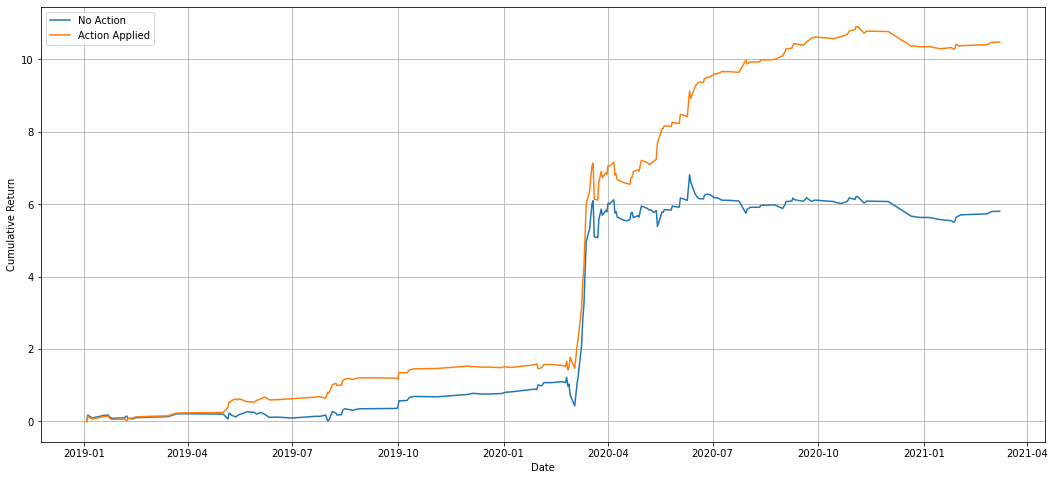

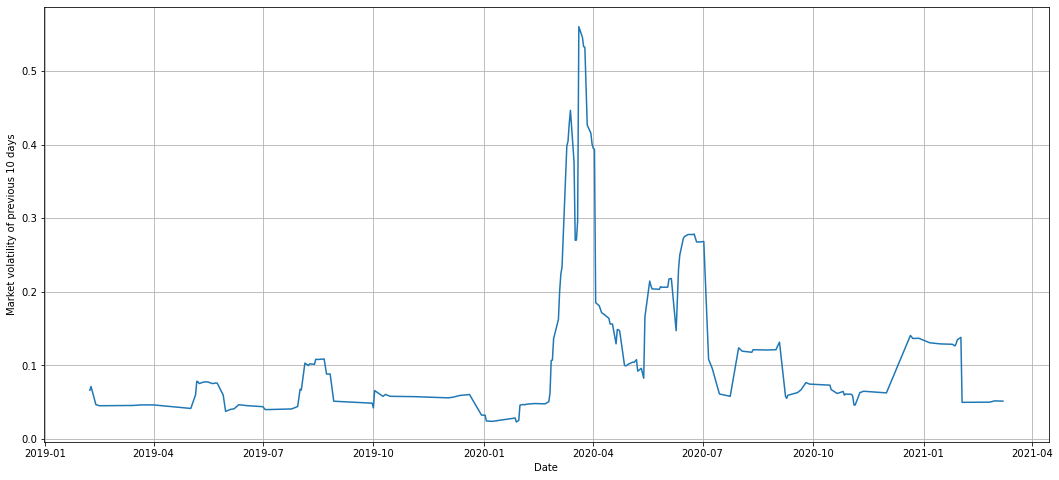


Market = stock_2, Learning Rate = 0.16, Window Size = 5, Datasets used = ['NASDAQ', 'VIX', 'SP500', 'USEUR', 'DAX']

Return without actions applied = 5.228418375770058

Return with actions applied = 7.9943284415073546

Excess return volatility = 1.212714058447051

Sharpe ratio of action returns to no action returns = 2.2807602884386453



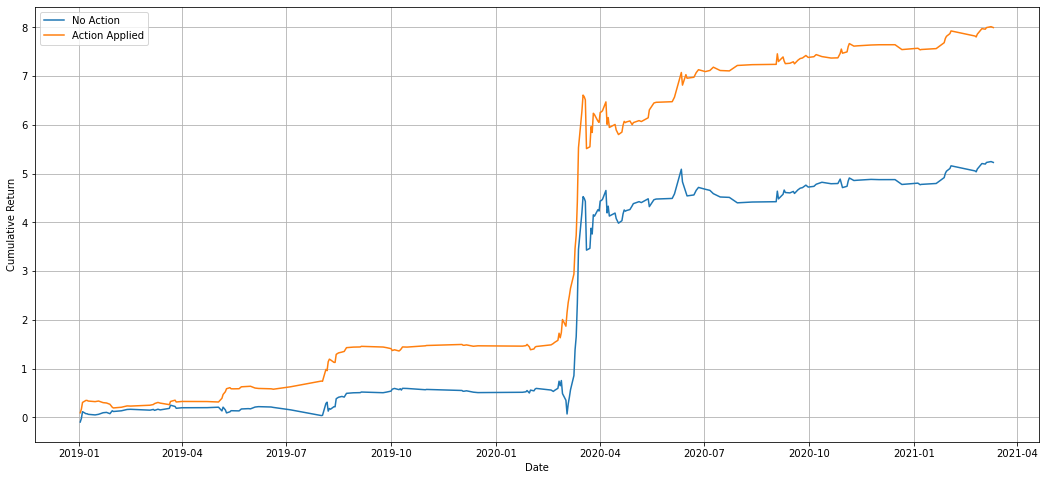

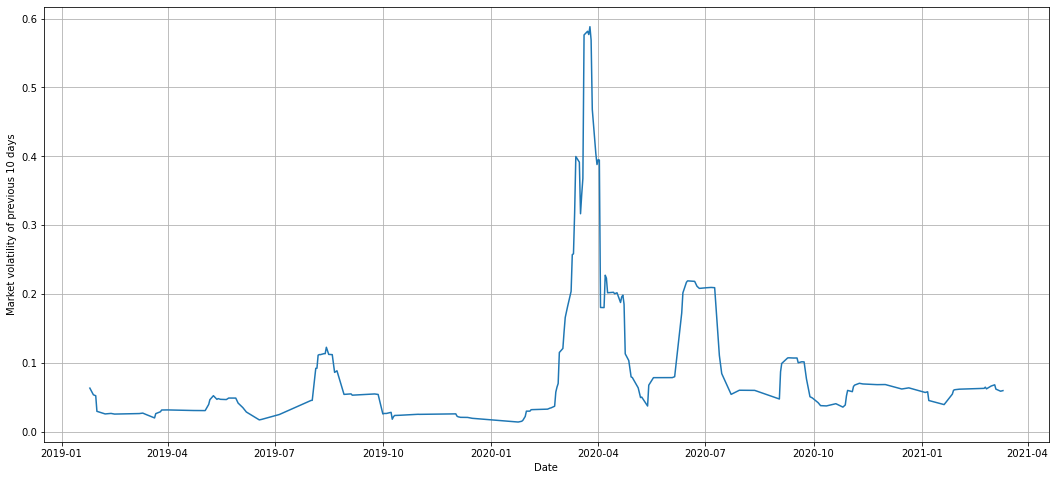


Market = bond_1, Learning Rate = 0.02, Window Size = 5, Datasets used = ['VIX', 'US10Y', 'UK10Y', 'DI']

Return without actions applied = 1.8229558706371827

Return with actions applied = 5.5442535756673035

Excess return volatility = 1.3262028689185557

Sharpe ratio of action returns to no action returns = 2.8059792300589965



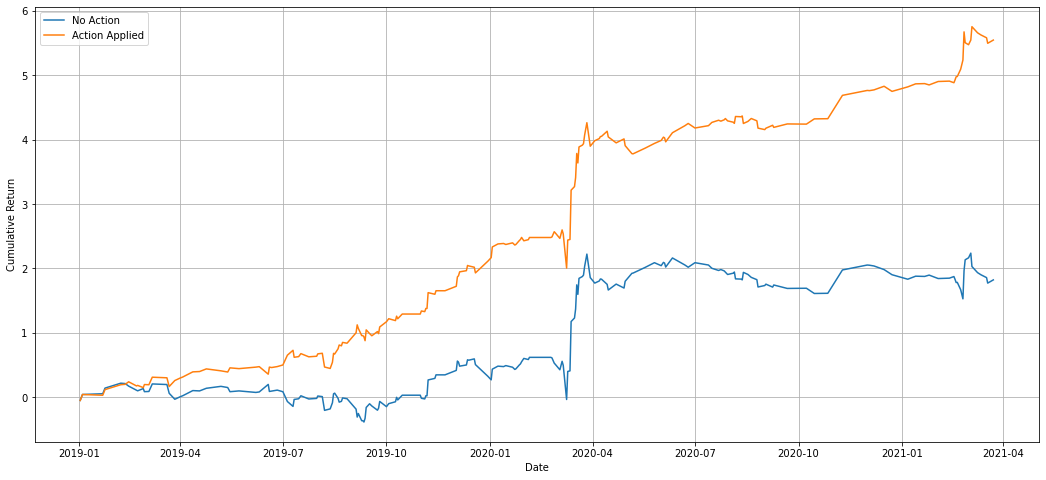

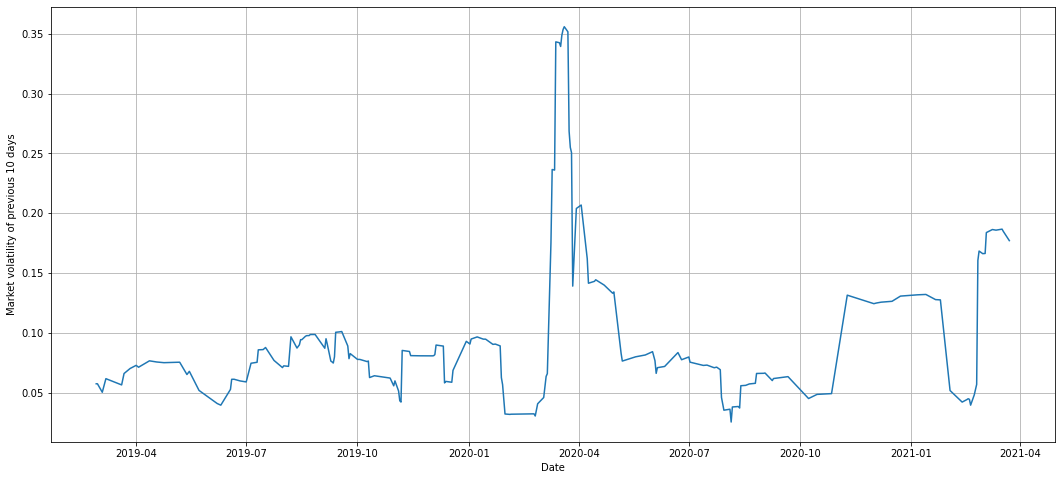


Market = bond_2, Learning Rate = 0.06, Window Size = 5, Datasets used = ['VIX', 'US10Y', 'UK10Y', 'DI']

Return without actions applied = 1.0553988821573668

Return with actions applied = 5.434194379880549

Excess return volatility = 1.4862997586915765

Sharpe ratio of action returns to no action returns = 2.946105233561994



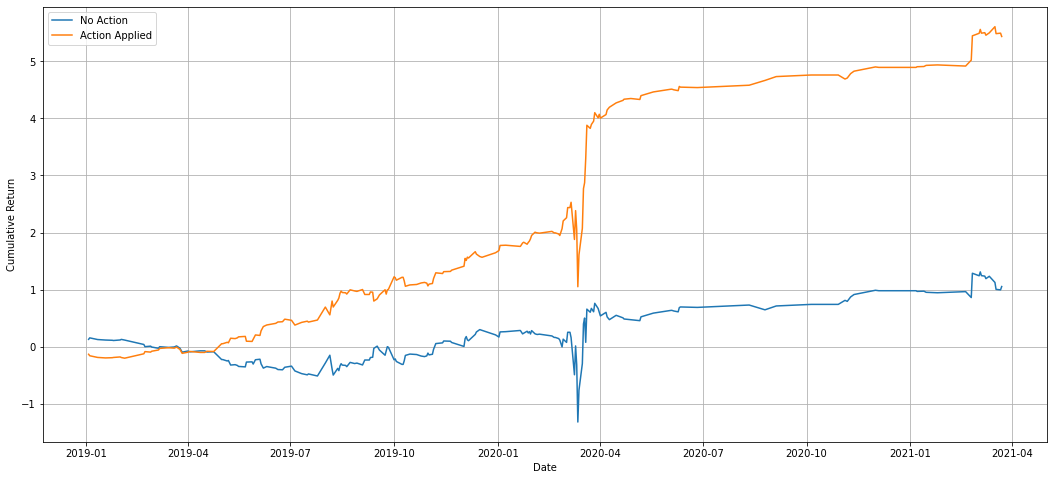

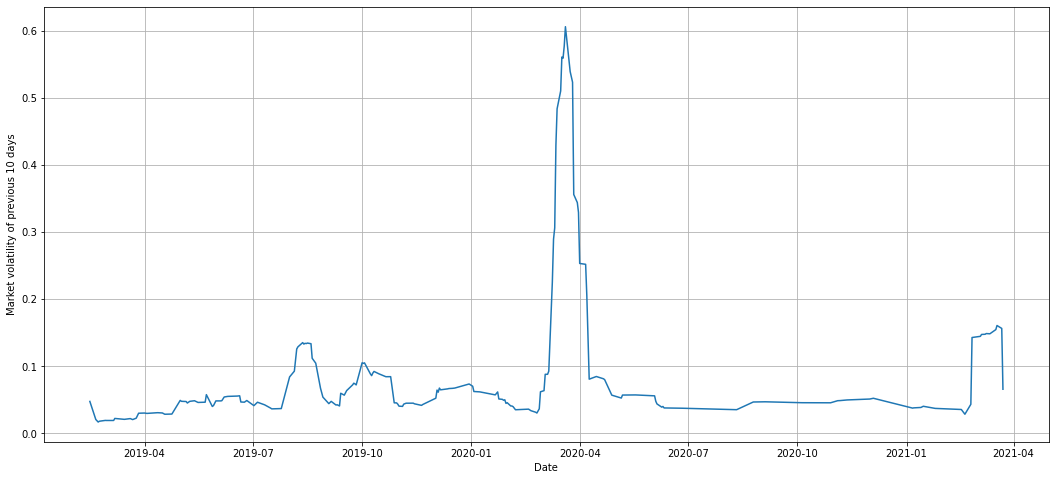


Market = commodity_1, Learning Rate = 0.03, Window Size = 5, Datasets used = ['OIL', 'GOLD', 'CR_OIL', 'DI']

Return without actions applied = 5.631320761738755

Return with actions applied = 13.763556105790963

Excess return volatility = 2.545233416899655

Sharpe ratio of action returns to no action returns = 3.195084305453632



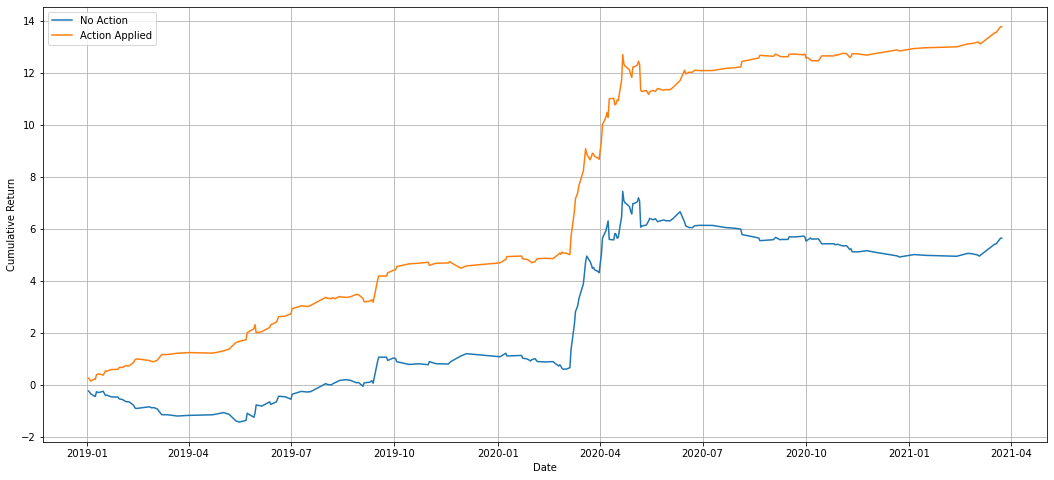

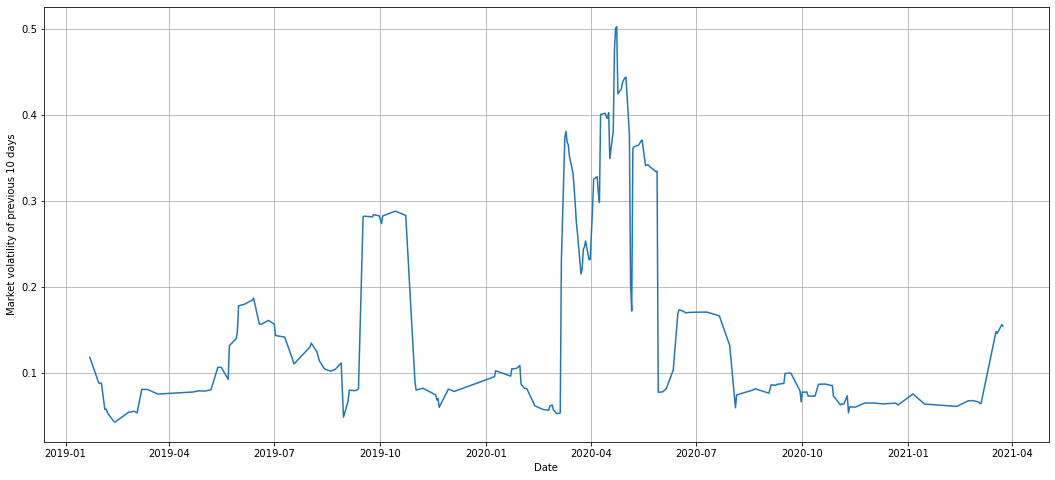


Market = commodity_2, Learning Rate = 0.11, Window Size = 5, Datasets used = ['OIL', 'GOLD', 'DI']

Return without actions applied = 4.540526222863631

Return with actions applied = 10.061148357317787

Excess return volatility = 2.959523594746376

Sharpe ratio of action returns to no action returns = 1.8653752733224145



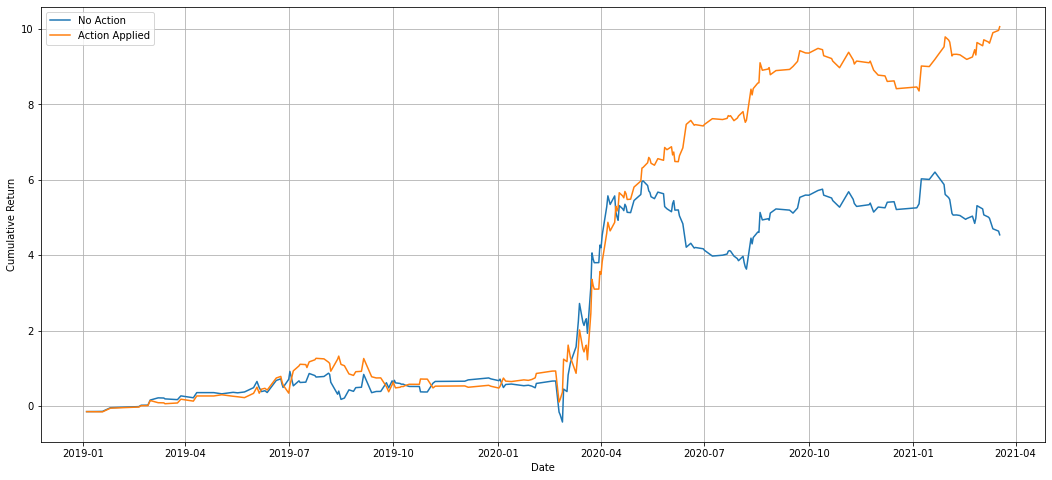

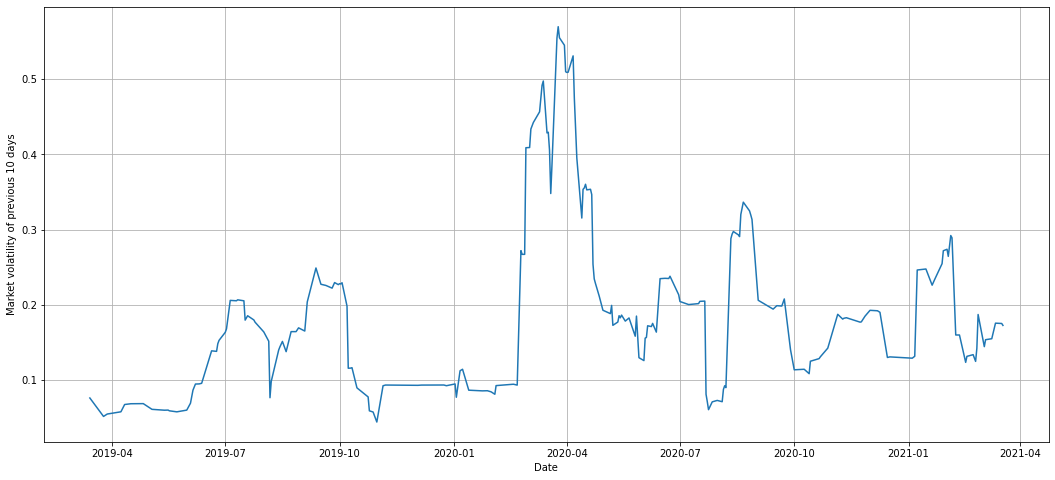


Market = currency_1, Learning Rate = 0.01, Window Size = 5, Datasets used = ['VIX', 'USJPY', 'USEUR', 'GBPUS', 'DI']

Return without actions applied = -0.7980328463450155

Return with actions applied = 4.131568456322043

Excess return volatility = 1.7758238177244658

Sharpe ratio of action returns to no action returns = 2.7759517883839577



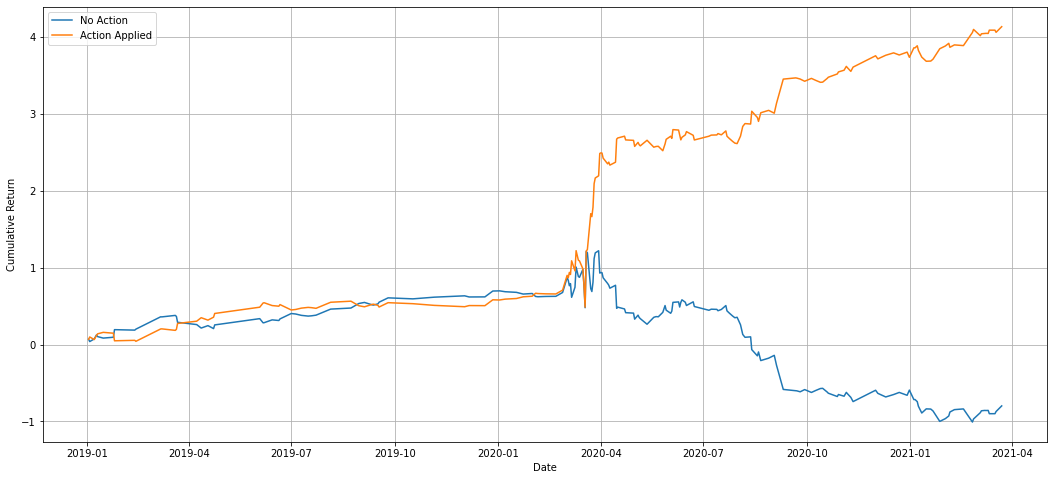

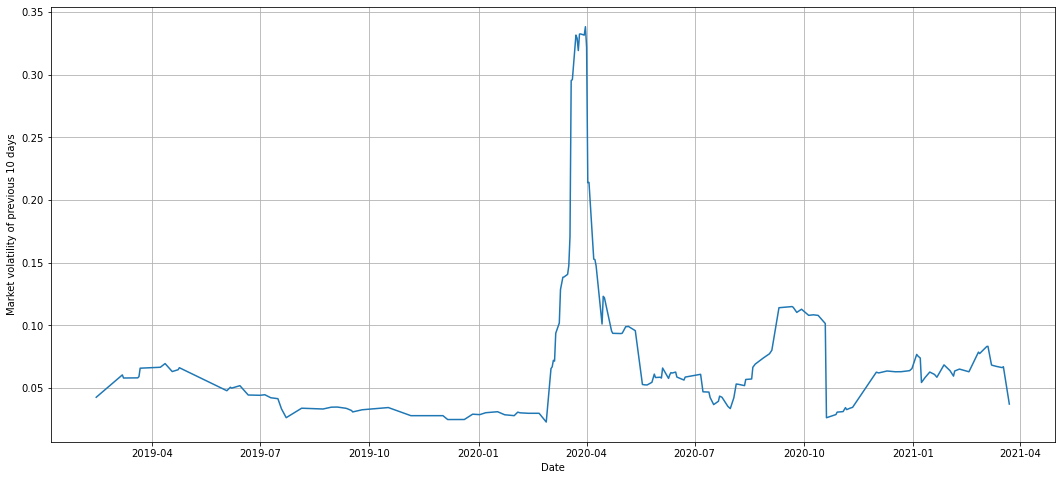


Market = currency_2, Learning Rate = 0.03, Window Size = 3, Datasets used = ['USEUR', 'USJPY', 'GBPUS', 'DI']

Return without actions applied = 3.625278500994363

Return with actions applied = 4.119058624051383

Excess return volatility = 0.8012704007853845

Sharpe ratio of action returns to no action returns = 0.6162465536890285



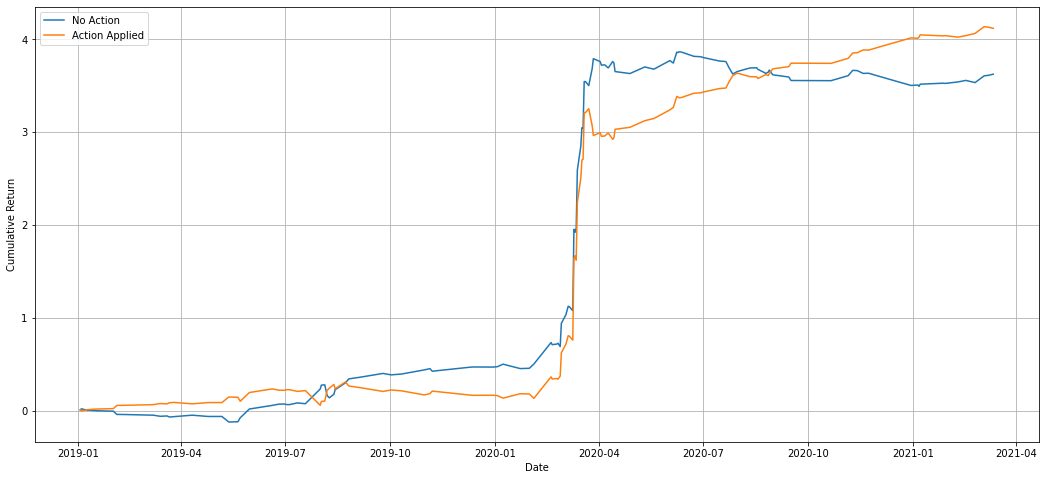

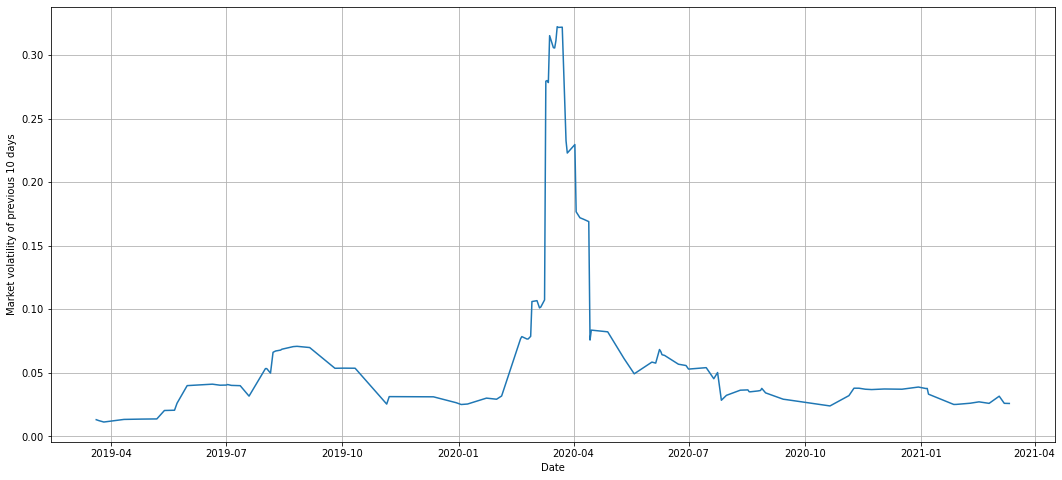

In [40]:
# run this cell to create models and visualise how each market does with model actions applied
portfolio = generate_portfolio(Markets, test_start_date, plot=True)

Portfolio return without actions applied = 26.912379032175398

Portfolio return with actions applied = 61.52791623070225

Portfolio excess return volatility = 6.13954151345316

Portfolio Sharpe Ratio = 5.63813065237464


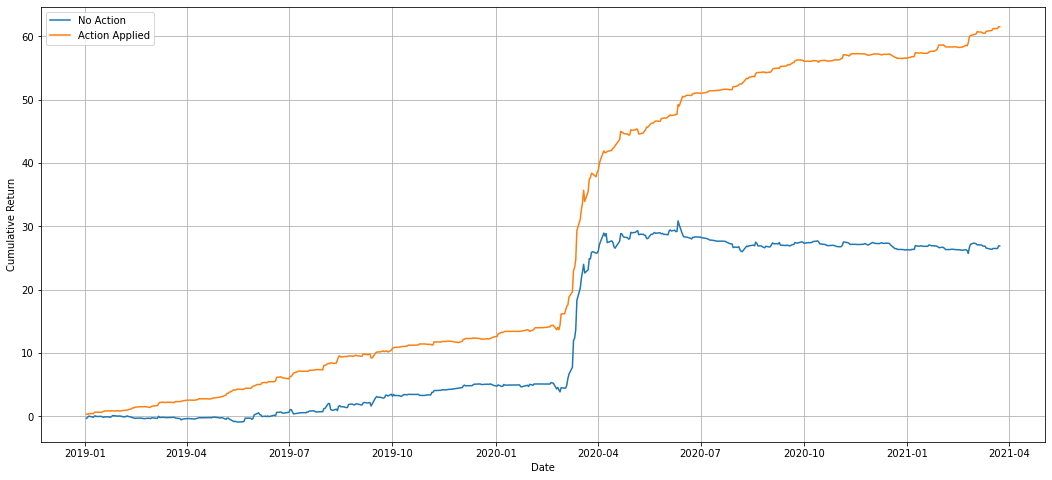

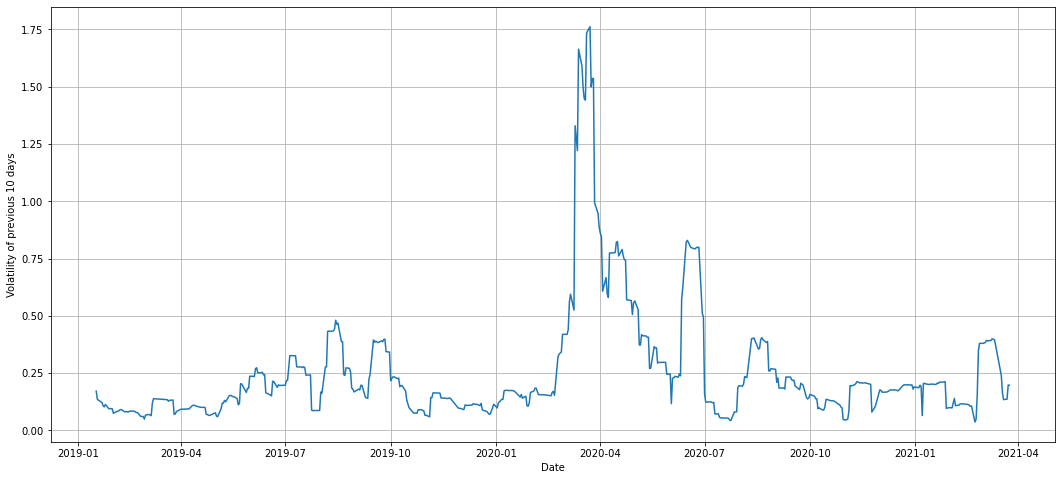

In [41]:
# run this cell to visualise how portfolio does as well as return Sharpe ratio
analyse_portfolio(portfolio, plot=True)